<a href="https://colab.research.google.com/github/haoboooo/Temporal-Generalization-of-Sentiment-Analysis-on-Amazon-Reviews/blob/main/video_games/game_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install emoji library
!pip install emot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 61 kB 15 kB/s 


In [ ]:
import pandas as pd
import numpy as np
import string

# store models
import pickle
from sklearn.pipeline import Pipeline

# text preprocessing
import nltk
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re
from emot.emo_unicode import EMOTICONS_EMO, UNICODE_EMOJI

# plots and metrics
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# feature extraction / vectorization
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


# classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## load the game data

In [ ]:
file1 = "./drive/MyDrive/Colab Notebooks/CL/game/97_06.csv"
file2 = "./drive/MyDrive/Colab Notebooks/CL/game/07_12.csv"
file3 = "./drive/MyDrive/Colab Notebooks/CL/game/13_17.csv"
file4 = "./drive/MyDrive/Colab Notebooks/CL/game/18.csv"

In [ ]:
def load_data(file):
  # read csv data and set columns
  df = pd.read_csv(file,usecols=['overall', 'reviewTime','reviewText'])

  # remove the duplicates if any
  df.duplicated('reviewText').sum()
  df.drop_duplicates(subset=['reviewText'],inplace=True)
  
  # remove NaN rows
  df.isnull().sum()
  df.dropna(how='any',axis=0,inplace=True)
  shape = df.shape
  counts = df.overall.value_counts()# labels count

  sns.countplot(df['overall']) # plot bar graph
  fig = plt.gcf() # get current figure
  fig.set_size_inches(5,5) # set the figure size
  plt.title('overall') # add title to the figure

  return df,shape,counts

(95385, 3)
 1.0    69406
-1.0    18035
 0.0     7944
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,1.0,2006,This game is a good time. Especially if you h...
1,0.0,2005,Don't expect the bells and whistles that you f...
2,1.0,2005,"It is fun to play this game, I really like it...."
3,1.0,2006,Here's the deal with this item: it's fine for ...
4,0.0,2006,We bought this for Christmas for our three kid...


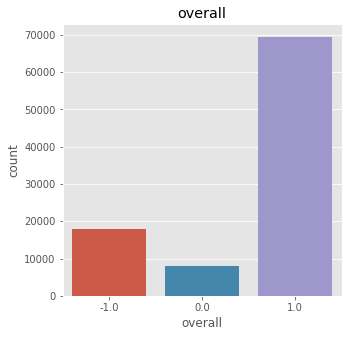

In [ ]:
# load data for 1997 - 2006
df1,shape1,counts1 = load_data(file1)
print(shape1)
print(counts1)
df1.head()

(273501, 3)
 1.0    193149
-1.0     55507
 0.0     24845
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,1.0,2012,I oredered this for a daughter who is now 33 a...
1,1.0,2010,Well I thought since this idem didn't have any...
2,1.0,2012,Good game. Good graphics. A bit of a learning ...
3,-1.0,2012,"If you buy this game, you will regret it. If ..."
4,1.0,2012,4 Stars because they like it and play it often...


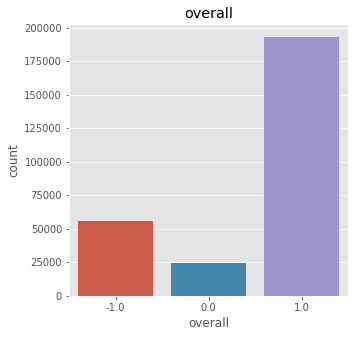

In [ ]:
# load data for 2007 - 2012
df2,shape2,counts2 = load_data(file2)
print(shape2)
print(counts2)
df2.head()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(957163, 3)
 1.0    672584
-1.0    210099
 0.0     74480
Name: overall, dtype: int64


,overall,reviewTime,reviewText
0,-1.0,2014,I used to play this game years ago and loved i...
1,0.0,2014,The game itself worked great but the story lin...
2,1.0,2014,I had to learn the hard way after ordering thi...
3,-1.0,2014,The product description should state this clea...
4,1.0,2014,I would recommend this learning game for anyon...


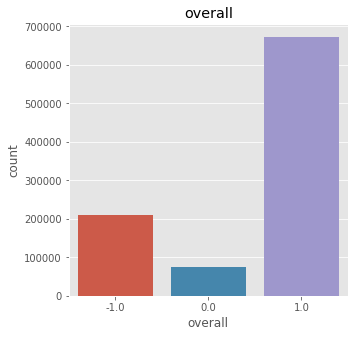

In [ ]:
# load data for 2013 - 2017
df3,shape3,counts3 = load_data(file3)
print(shape3)
print(counts3)
df3.head()

(80396, 3)
 1.0    52744
-1.0    21618
 0.0     6034
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,1.0,2018,No complaints! Sing your little heart out!
1,1.0,2018,Works great with Xbox 360. I have 2 of these u...
2,1.0,2018,The game was perfect and super clean. Very ple...
3,1.0,2018,It was perfect gift. Got it for Christmas and ...
4,1.0,2018,Lik3d it


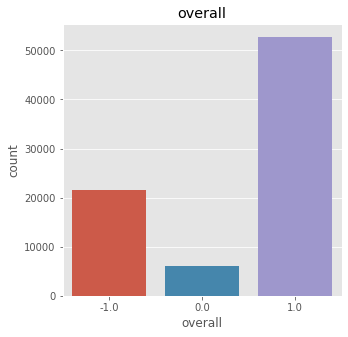

In [ ]:
# load data for 2018
df4,shape4,counts4 = load_data(file4)
print(shape4)
print(counts4)
df4.head()

## Split and Balance train&test

#### Split and Balance for each time period

In [ ]:
def split_balance(df,counts):
  # get data of each class
  groups = df.groupby(df.overall)
  pos = groups.get_group(1)
  neu = groups.get_group(0)
  neg = groups.get_group(-1)

  # shuffle the dataframe
  pos = pos.sample(frac=1.0)
  neu = neu.sample(frac=1.0)
  neg = neg.sample(frac=1.0)

  # compute the index to split 80% for train 20% for test
  posind = int(counts[1]*0.8)
  neuind = int(counts[0]*0.8)
  negind = int(counts[-1]*0.8)

  # split to get train for each class
  pos_train = pos.iloc[:posind,:]
  neu_train = neu.iloc[:neuind,:]
  neg_train = neg.iloc[:negind,:]

  # split to get test for each class
  pos_test = pos.iloc[posind:,:]
  neu_test = neu.iloc[neuind:,:]
  neg_test = neg.iloc[negind:,:]

  # combine train dataset
  df_train = pd.concat([pos_train, neu_train, neg_train],sort=False).sample(frac=1.0)
  df_train_label = df_train.overall

  # combine test dataset
  df_test = pd.concat([pos_test, neu_test, neg_test],sort=False).sample(frac=1.0)
  df_test_label = df_test.overall

  return df_train,df_train_label,df_test,df_test_label

In [ ]:
# split train and test data for 1997 - 2006
df1_train,df1_train_label,df1_test,df1_test_label = split_balance(df1,counts1)

# get train and test text
df1_train_data = df1_train.iloc[:10000,:].reviewText
df1_train_label = df1_train_label.iloc[:10000]
df1_test_data = df1_test.iloc[:10000,:].reviewText
df1_test_label = df1_test_label.iloc[:10000]

In [ ]:
# split train and test data for 2007 - 2012
df2_train,df2_train_label,df2_test,df2_test_label = split_balance(df2,counts2)

# get train and test text
df2_train_data = df2_train.iloc[:10000,:].reviewText
df2_train_label = df2_train_label.iloc[:10000]
df2_test_data = df2_test.iloc[:10000,:].reviewText
df2_test_label = df2_test_label.iloc[:10000]

In [ ]:
# split train and test data for 2013 - 2017
df3_train,df3_train_label,df3_test,df3_test_label = split_balance(df3,counts3)

# get train and test text
df3_train_data = df3_train.iloc[:10000,:].reviewText
df3_train_label = df3_train_label.iloc[:10000]
df3_test_data = df3_test.iloc[:10000,:].reviewText
df3_test_label = df3_test_label.iloc[:10000]

In [ ]:
# split train and test data for 2018
df4_train,df4_train_label,df4_test,df4_test_label = split_balance(df4,counts4)

# get train and test text
df4_train_data = df4_train.iloc[:10000,:].reviewText
df4_train_label = df4_train_label.iloc[:10000]
df4_test_data = df4_test.iloc[:10000,:].reviewText
df4_test_label = df4_test_label.iloc[:10000]

In [ ]:
df4_test_data.shape

(10000,)

## Text Preprocessing

In [ ]:
# Defining my NLTK stop words and my user-defined stop words
emojis = {**UNICODE_EMOJI,**EMOTICONS_EMO} # full list of emojis unicodes

In [ ]:
def processtext(txt):
  # convert tweet to lower case
  txt = txt.lower()
  # remove all html tag
  txt = re.sub("(<.*?>)", "", txt)
  # remove all urls
  txt = re.sub('https?:\/\/\S+','',txt)
  # remove @ references  
  txt = re.sub('@[\w_]+','',txt)
  # remove # hashtags
  txt = re.sub('#\S+','',txt)
  # replace all emojis
  for emo in emojis.keys():
    txt = txt.replace(emo,"EMOJI "+emojis[emo])
  # remove all multiple white spaces
  txt = re.sub('[\s]+',' ',txt)
  # remove all punctuations and non-ascii
  txt = re.sub('[\.?!,;:\-\[\]\{\}\(\)\'\"/]','',txt)
  # remove whitespace
  txt = txt.strip()

  # tokenization with nltk
  data = word_tokenize(txt)
  # stemming with nltk
  porter = PorterStemmer()
  stem_data = [porter.stem(word) for word in data]
  return stem_data

## Text Representation

#### Learn on 1997-2006;Estimate on 2018

In [ ]:
# 5min
# TFIDF, unigrams and trigrams
tf_vect1 = TfidfVectorizer(tokenizer=processtext, sublinear_tf=True, norm='l2', ngram_range=(1,3))
# fit on previous data
tf_vect1.fit_transform(df1_train_data)

# transform testing and training datasets to vectors
df1_train_vect = tf_vect1.transform(df1_train_data)
df1_test_vect = tf_vect1.transform(df1_test_data)

# transform on 2018 test data
df4_test_vect = tf_vect1.transform(df4_test_data)

#### Learn on 2007-2012;Estimate on 2018

In [ ]:
# 5min
tf_vect2 = TfidfVectorizer(tokenizer=processtext, sublinear_tf=True, norm='l2', ngram_range=(1,3))
tf_vect2.fit_transform(df2_train_data)
df2_train_vect = tf_vect2.transform(df2_train_data)
df2_test_vect = tf_vect2.transform(df2_test_data)

# transform on 2018 test data
df4_test_vect2 = tf_vect2.transform(df4_test_data)

### Learn on 2013-2017;Estimate on 2018

In [ ]:
# 5min
tf_vect3 = TfidfVectorizer(tokenizer=processtext, sublinear_tf=True, norm='l2', ngram_range=(1,3))
tf_vect3.fit_transform(df3_train_data)
df3_train_vect = tf_vect3.transform(df3_train_data)
df3_test_vect = tf_vect3.transform(df3_test_data)

# transform on 2018 test data
df4_test_vect3 = tf_vect3.transform(df4_test_data)

## Classifiers

### Learn on 1997-2006;Estimate on 2018

#### Linear Support Vector

In [ ]:
svc1 = LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
svc1.fit(df1_train_vect, df1_train_label)
ysvm_pred = svc1.predict(df1_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(df1_test_label, ysvm_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df1_test_label, ysvm_pred, average='micro') * 100))

Accuracy: 82.89%

F1 Score: 82.89


In [ ]:
# estimate on 2018 data
ysvm_pred_18 = svc1.predict(df4_test_vect)
print("Accuracy: {:.2f}%".format(accuracy_score(df4_test_label, ysvm_pred_18) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df4_test_label, ysvm_pred_18, average='micro') * 100))

Accuracy: 78.79%

F1 Score: 78.79


#### Logistic Regression

In [ ]:
lr1=LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
lr1.fit(df1_train_vect, df1_train_label)
ylog_pred = lr1.predict(df1_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(df1_test_label, ylog_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df1_test_label, ylog_pred, average='micro') * 100))

Accuracy: 82.17%

F1 Score: 82.17


In [ ]:
ylog_pred_18 = lr1.predict(df4_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(df4_test_label, ylog_pred_18) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df4_test_label, ylog_pred_18, average='micro') * 100))

Accuracy: 78.39%

F1 Score: 78.39


#### Naive Bayes

In [ ]:
nb1 = MultinomialNB(alpha=0.1,fit_prior=True)

nb1.fit(df1_train_vect, df1_train_label)
ynb_pred = nb1.predict(df1_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(df1_test_label, ynb_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df1_test_label, ynb_pred, average='micro') * 100))

Accuracy: 72.85%

F1 Score: 72.85


In [ ]:
ynb_pred_18 = nb1.predict(df4_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(df4_test_label, ynb_pred_18) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df4_test_label, ynb_pred_18, average='micro') * 100))

Accuracy: 66.40%

F1 Score: 66.40


#### Random Forest

In [ ]:
rf1= RandomForestClassifier(n_estimators=100,criterion='entropy',n_jobs=-1)

rf1.fit(df1_train_vect, df1_train_label)
yrf_pred = rf1.predict(df1_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(df1_test_label, yrf_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df1_test_label, yrf_pred, average='micro') * 100))

Accuracy: 73.37%

F1 Score: 73.37


In [ ]:
yrf_pred_18 = rf1.predict(df4_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(df4_test_label, yrf_pred_18) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df4_test_label, yrf_pred_18, average='micro') * 100))

Accuracy: 66.77%

F1 Score: 66.77


### Learn on 2007-2012;Estimate on 2018

#### Linear Support Vector

In [ ]:
svc2 = LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
svc2.fit(df2_train_vect, df2_train_label)
ysvm_pred2 = svc2.predict(df2_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(df2_test_label, ysvm_pred2) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df2_test_label, ysvm_pred2, average='micro') * 100))

Accuracy: 83.75%

F1 Score: 83.75


In [ ]:
# estimate on 2018 data
ysvm_pred2_18 = svc2.predict(df4_test_vect2)
print("Accuracy: {:.2f}%".format(accuracy_score(df4_test_label, ysvm_pred2_18) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df4_test_label, ysvm_pred2_18, average='micro') * 100))

Accuracy: 82.32%

F1 Score: 82.32


#### Logistic Regression

In [ ]:
lr2=LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
lr2.fit(df2_train_vect, df2_train_label)
ylog_pred2 = lr2.predict(df2_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(df2_test_label, ylog_pred2) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df2_test_label, ylog_pred2, average='micro') * 100))

Accuracy: 83.26%

F1 Score: 83.26


In [ ]:
ylog_pred2_18 = lr2.predict(df4_test_vect2)

print("Accuracy: {:.2f}%".format(accuracy_score(df4_test_label, ylog_pred2_18) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df4_test_label, ylog_pred2_18, average='micro') * 100))

Accuracy: 81.73%

F1 Score: 81.73


#### Naive Bayes

In [ ]:
nb2 = MultinomialNB(alpha=0.1,fit_prior=True)

nb2.fit(df2_train_vect, df2_train_label)
ynb_pred2 = nb2.predict(df2_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(df2_test_label, ynb_pred2) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df2_test_label, ynb_pred2, average='micro') * 100))

Accuracy: 72.43%

F1 Score: 72.43


In [ ]:
ynb_pred2_18 = nb2.predict(df4_test_vect2)

print("Accuracy: {:.2f}%".format(accuracy_score(df4_test_label, ynb_pred2_18) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df4_test_label, ynb_pred2_18, average='micro') * 100))

Accuracy: 68.61%

F1 Score: 68.61


#### Random Forest

In [ ]:
rf2= RandomForestClassifier(n_estimators=100,criterion='entropy',n_jobs=-1)

rf2.fit(df2_train_vect, df2_train_label)
yrf_pred2 = rf2.predict(df2_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(df2_test_label, yrf_pred2) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df2_test_label, yrf_pred2, average='micro') * 100))

Accuracy: 73.40%

F1 Score: 73.40


In [ ]:
yrf_pred2_18 = rf2.predict(df4_test_vect2)

print("Accuracy: {:.2f}%".format(accuracy_score(df4_test_label, yrf_pred2_18) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df4_test_label, yrf_pred2_18, average='micro') * 100))

Accuracy: 68.03%

F1 Score: 68.03


### Learn on 2013-2017;Estimate on 2018

#### Linear Support Vector

In [ ]:
svc3 = LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
svc3.fit(df3_train_vect, df3_train_label)
ysvm_pred3 = svc3.predict(df3_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(df3_test_label, ysvm_pred3) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df3_test_label, ysvm_pred3, average='micro') * 100))

Accuracy: 85.09%

F1 Score: 85.09


In [ ]:
# estimate on 2018 data
ysvm_pred3_18 = svc3.predict(df4_test_vect3)
print("Accuracy: {:.2f}%".format(accuracy_score(df4_test_label, ysvm_pred3_18) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df4_test_label, ysvm_pred3_18, average='micro') * 100))

Accuracy: 85.26%

F1 Score: 85.26


#### Logistic Regression

In [ ]:
lr3=LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
lr3.fit(df3_train_vect, df3_train_label)
ylog_pred3 = lr3.predict(df3_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(df3_test_label, ylog_pred3) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df3_test_label, ylog_pred3, average='micro') * 100))

Accuracy: 84.98%

F1 Score: 84.98


In [ ]:
ylog_pred3_18 = lr3.predict(df4_test_vect3)

print("Accuracy: {:.2f}%".format(accuracy_score(df4_test_label, ylog_pred3_18) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df4_test_label, ylog_pred3_18, average='micro') * 100))

Accuracy: 84.72%

F1 Score: 84.72


#### Naive Bayes

In [ ]:
nb3 = MultinomialNB(alpha=0.1,fit_prior=True)

nb3.fit(df3_train_vect, df3_train_label)
ynb_pred3 = nb3.predict(df3_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(df3_test_label, ynb_pred3) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df3_test_label, ynb_pred3, average='micro') * 100))

Accuracy: 76.81%

F1 Score: 76.81


In [ ]:
ynb_pred3_18 = nb3.predict(df4_test_vect3)

print("Accuracy: {:.2f}%".format(accuracy_score(df4_test_label, ynb_pred3_18) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df4_test_label, ynb_pred3_18, average='micro') * 100))

Accuracy: 75.19%

F1 Score: 75.19


#### Random Forest

In [ ]:
# estimated 5hrs
rf3= RandomForestClassifier(n_estimators=100,criterion='entropy',n_jobs=-1)
rf3.fit(df3_train_vect, df3_train_label)
yrf_pred3 = rf3.predict(df3_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(df3_test_label, yrf_pred3) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df3_test_label, yrf_pred3, average='micro') * 100))

Accuracy: 77.53%

F1 Score: 77.53


In [ ]:
yrf_pred3_18 = rf3.predict(df4_test_vect3)

print("Accuracy: {:.2f}%".format(accuracy_score(df4_test_label, yrf_pred3_18) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df4_test_label, yrf_pred3_18, average='micro') * 100))

Accuracy: 75.64%

F1 Score: 75.64


## store models

In [ ]:
def store_model(i,vect,svm,lr,nb,rf):
  pipe1 = Pipeline([
    ('tfidf', vect),
    ('svm', svm),
    ])
  pipe2 = Pipeline([
    ('tfidf', vect),
    ('lr', lr),
    ])
  pipe3 = Pipeline([
    ('tfidf', vect),
    ('nb', nb),
    ])
  pipe4 = Pipeline([
    ('tfidf', vect),
    ('rf', rf),
    ])
  if i == 1:
    dir = '97_06'
  elif i == 2:
    dir = '07_12'
  else:
    dir = '13_17'
  filename1 = './drive/MyDrive/Colab Notebooks/CL/game/'+dir+'/svm.pickle'
  filename2 = './drive/MyDrive/Colab Notebooks/CL/game/'+dir+'/lr.pickle'
  filename3 = './drive/MyDrive/Colab Notebooks/CL/game/'+dir+'/nb.pickle'
  filename4 = './drive/MyDrive/Colab Notebooks/CL/game/'+dir+'/rf.pickle'
  pickle.dump(pipe1, open(filename1, 'wb'))
  pickle.dump(pipe2, open(filename2, 'wb'))
  pickle.dump(pipe3, open(filename3, 'wb'))
  pickle.dump(pipe4, open(filename4, 'wb'))

In [ ]:
store_model(1,tf_vect1,svc1,lr1,nb1,rf1)

In [ ]:
store_model(2,tf_vect2,svc2,lr2,nb2,rf2)

In [ ]:
store_model(3,tf_vect3,svc3,lr3,nb3,rf3)